In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from prophet import Prophet
import pandas as pd 
orig_df = pd.read_csv("resource/kz.csv")

In [2]:
sales_df = orig_df.copy()
sales_df['event_time'] = sales_df['event_time'].apply(lambda x: x.replace("UTC", ""))
#sales_stripped_df = pd.DataFrame(sales_df, columns = ['event_time','order_id'], index = ['event_time'])
sales_df['event_time'] = pd.to_datetime(sales_df['event_time'])
sales_df_stripped = sales_df[[ 'event_time', 'order_id']]
sales_df_stripped_per_hr = sales_df_stripped.groupby(pd.Grouper(key='event_time', axis=0, freq='H')).count()
sales_df_stripped_per_hr = sales_df_stripped_per_hr.loc['2021-01-01':'2021-01-31'].loc[sales_df_stripped_per_hr['order_id'] > 0]
sales_df_stripped_per_hr = sales_df_stripped_per_hr.loc[sales_df_stripped_per_hr['order_id'] > 100]
sales_df_stripped_per_hr.dropna(inplace=True)

In [3]:
sales_df_stripped_per_hr.tail()         

,order_id
event_time,
2021-01-31 11:00:00,941
2021-01-31 12:00:00,959
2021-01-31 13:00:00,860
2021-01-31 14:00:00,516
2021-01-31 15:00:00,317


In [4]:
sales_df_stripped_per_hr.reset_index(inplace=True)
sales_df_stripped_per_hr.columns = ['ds', 'y']

In [5]:

sales_df_stripped_per_hr.describe()

,y
count,328.000000
mean,808.679878
std,433.403349
min,139.000000
25%,504.500000
50%,760.000000
75%,1018.250000
max,1962.000000


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(sales_df_stripped_per_hr, test_size=0.3, shuffle=False)

In [7]:
df_train = X_train.copy()
df_train.sort_index(inplace=True)
print(X_test.tail(),df_train.tail())

                     ds    y
323 2021-01-31 11:00:00  941
324 2021-01-31 12:00:00  959
325 2021-01-31 13:00:00  860
326 2021-01-31 14:00:00  516
327 2021-01-31 15:00:00  317                      ds    y
224 2021-01-23 10:00:00  871
225 2021-01-23 11:00:00  658
226 2021-01-23 12:00:00  702
227 2021-01-23 13:00:00  613
228 2021-01-23 14:00:00  357


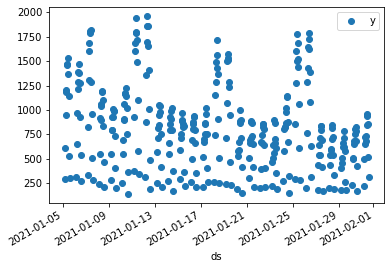

In [8]:
# current order trend is a linear function with seasonality
from matplotlib import pyplot
sales_df_stripped_per_hr.plot(x='ds', y='y', style='o')
pyplot.show() 

In [9]:
#m = Prophet('growth= 'logistic)
m = Prophet(growth='linear',weekly_seasonality=True,daily_seasonality='auto',yearly_seasonality='auto')
m.add_seasonality('self_define_cycle',period=1,fourier_order=8,mode='additive')
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
m.fit(df_train)
# simple model to start with. we can interact with the model to change the parameters e.g logistic growth
# try other timeseries models starting ARIMA, variatios in prophet, etc

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [11]:
future = m.make_future_dataframe(periods=len(X_test),freq='H')
future_dates = pd.merge(future, (df_train.append(X_test)).drop('y', axis=1), on = 'ds')
future_dates.tail()

,ds
275,2021-01-27 11:00:00
276,2021-01-27 12:00:00
277,2021-01-27 13:00:00
278,2021-01-27 14:00:00
279,2021-01-27 15:00:00


In [12]:
future['cap'] = 2000 # set the cap to 20k
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
275,2021-01-27 11:00:00,845.765523,641.557830,1053.643782
276,2021-01-27 12:00:00,762.605841,530.844677,992.235098
277,2021-01-27 13:00:00,544.484912,317.820801,776.715872
278,2021-01-27 14:00:00,168.833075,-62.952750,395.920125
279,2021-01-27 15:00:00,-54.406939,-275.687155,170.750399


<ipython-input-13-9356221cd325>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig1.add_subplot(1, 1, 1)


Text(0.5, 33.0, 'Date')

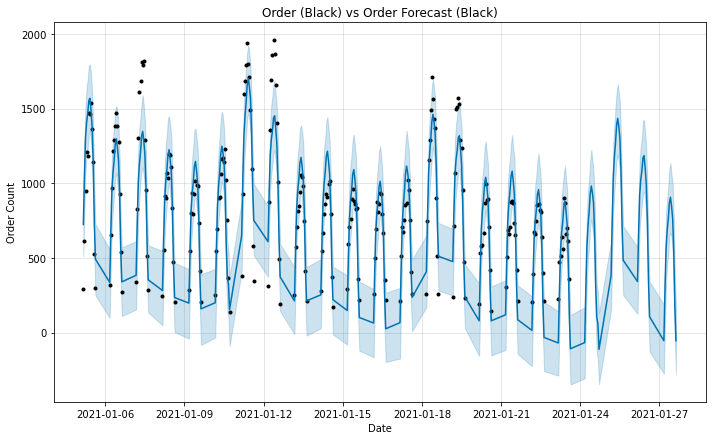

In [13]:
import matplotlib.pyplot as plt
fig1 = m.plot(forecast)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('Order (Black) vs Order Forecast (Black)')
ax1.set_ylabel('Order Count')
ax1.set_xlabel('Date')

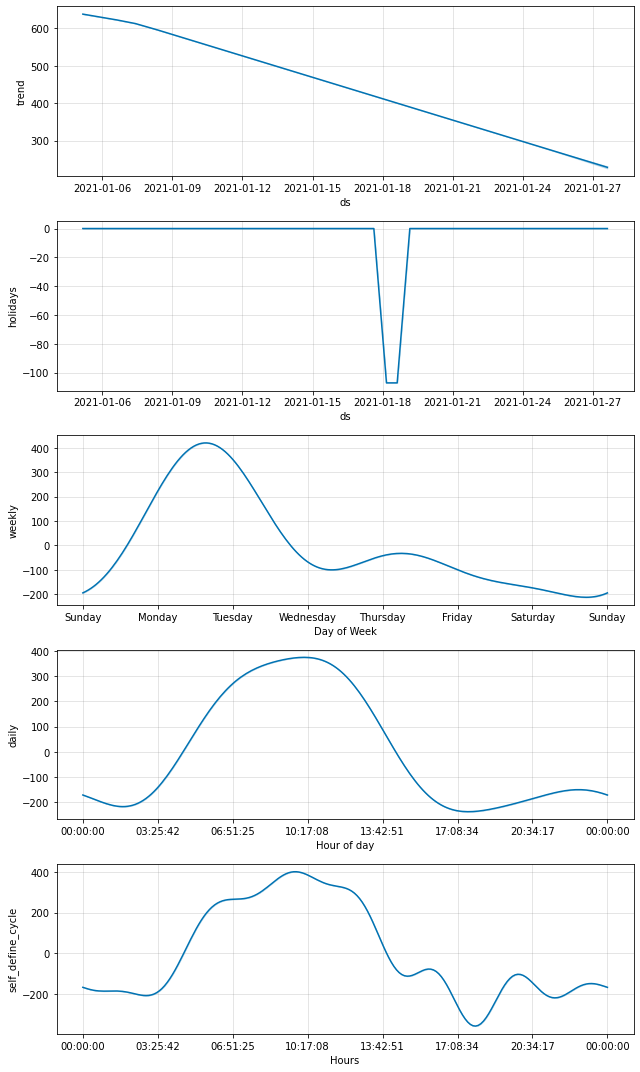

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [84]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [80]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = sales_df_stripped_per_hr['ds'].values
y_prophet['y'] = sales_df_stripped_per_hr['y'].values
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [91]:
y_prophet.tail()

,y
ds,
2021-01-31 11:00:00,941
2021-01-31 12:00:00,959
2021-01-31 13:00:00,860
2021-01-31 14:00:00,516
2021-01-31 15:00:00,317


In [92]:
forecast_prophet.tail(5)
#forecast.tail(5)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,...,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-27 11:00:00,231.741373,641.557830,1053.643782,228.928934,234.544850,0.0,0.0,0.0,0.0,0.0,...,347.300913,347.300913,347.300913,-95.336271,-95.336271,-95.336271,0.0,0.0,0.0,845.765523
2021-01-27 12:00:00,230.946447,530.844677,992.235098,228.087046,233.814681,0.0,0.0,0.0,0.0,0.0,...,320.791817,320.791817,320.791817,-92.444936,-92.444936,-92.444936,0.0,0.0,0.0,762.605841
2021-01-27 13:00:00,230.151521,317.820801,776.715872,227.231006,233.095343,0.0,0.0,0.0,0.0,0.0,...,212.212645,212.212645,212.212645,-89.003880,-89.003880,-89.003880,0.0,0.0,0.0,544.484912
2021-01-27 14:00:00,229.356596,-62.952750,395.920125,226.390040,232.338337,0.0,0.0,0.0,0.0,0.0,...,-21.431554,-21.431554,-21.431554,-85.110943,-85.110943,-85.110943,0.0,0.0,0.0,168.833075
2021-01-27 15:00:00,228.561670,-275.687155,170.750399,225.534625,231.586691,0.0,0.0,0.0,0.0,0.0,...,-110.155077,-110.155077,-110.155077,-80.864658,-80.864658,-80.864658,0.0,0.0,0.0,-54.406939


In [90]:
evaluate_forecast(y_prophet.y[10:100], forecast_prophet.yhat[10:100])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.822814,152.596861,94.567774,45820.660736,0.060061,0.183428,214.057611
